In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools 
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import datajoint as dj
from collections import defaultdict
import pycircstat as pycs
from funconnect import morphology, connectomics, ta3, nda
from tqdm import tqdm
import scipy.stats as stats


Connecting celiib@10.28.0.34:3306


In [2]:
#setting the address and the username
dj.config['database.host'] = '10.28.0.34'
dj.config['database.user'] = 'celiib'
dj.config['database.password'] = 'newceliipass'
dj.config['safemode']=True
dj.config["display.limit"] = 20


pinky = dj.create_virtual_module('pinky', 'microns_pinky')
ndap100 = dj.create_virtual_module('pinky_nda', 'microns_pinky_nda')
radtune = dj.create_virtual_module('pinky_radtune', 'microns_pinky_radtune')
spattune = dj.create_virtual_module('pinky_spattune', 'microns_pinky_spattune')
fc = dj.create_virtual_module('pinky_fc', 'microns_pinky_fc')


In [3]:
synapse = (pinky.Synapse - pinky.SynapseExclude) & pinky.CurrentSegmentation
segment = (pinky.Segment - pinky.SegmentExclude) & pinky.CurrentSegmentation
soma = (pinky.AllenSoma - pinky.SegmentExclude) & pinky.CurrentSegmentation
soma = soma & "cell_class='excitatory'"

In [4]:
"""
WHERE THE RF CORRELATION BINS ARE EXPLICITELY SET
"""

attrs = ['segment_a', 'segment_b', 'connection', 'n_seg_shared']
good_rf = 'mscore > 1.25'

cbin_edges = np.linspace(-.7, .7, 6) #setting the bin boundaries
#calculates the centers of the bins used for the receptive field
cbin_centers = np.hstack((np.nan, np.round((cbin_edges[1:] + cbin_edges[:-1])/2, decimals=2), np.nan))
#creates labels for the receptive field edges
cbin_labels = ['[{:.1f},{:.1f}]'.format(*a) for a in zip(cbin_edges[:-1], cbin_edges[1:])]
cbin_labels

['[-0.7,-0.4]', '[-0.4,-0.1]', '[-0.1,0.1]', '[0.1,0.4]', '[0.4,0.7]']

In [5]:
# #Test to see if the binning makes a difference


# #check that would still get the same bins
# union_edges = np.linspace(min(cdf['rf_corr_coef']), max(cdf['rf_corr_coef']), 6)
# ue = list(['{:.2f}'.format(ee) for ee in union_edges])
# union_labels = list(zip(ue[:-1], ue[1:]))
# union_centers = np.hstack((np.nan, np.round((union_edges[1:] + union_edges[:-1])/2, decimals=2), np.nan))
# union_centers

In [6]:
"""
Calculate the bins and centers for the orientational preference
"""
#defines how to find the "tuned" segments of the orientation
dori_resolution = np.pi / 2 / 4 #setting the width size of the bins to be 22.5 degrees
rad2deg = 180/np.pi
bin_edges = np.linspace(0, np.pi,9) #creates 8 bins between boundaries between 0 and pi

# turns all of the bin edges into degrees with no decimal
be = list(['{:.0f}'.format(ee) for ee in [np.round(e * rad2deg) for e in bin_edges]])
#creates the bin boundary markings with [low - high]
bin_labels = list(zip(be[:-1], be[1:]))

#calculates the bin centers
bin_centers = np.round((bin_edges[1:] + bin_edges[:-1])/2 * rad2deg, decimals=2) 

In [7]:
"""
Gets the segments with the acceptable rf thresholds
"""

# functional metrics for each functional soma pair (restricting by spattune fitting significance)

sig_units_rf = spattune.BestSTA.Loc & 'sta_snr > 1.25' & segment
sig_unit_pairs_rf = (sig_units_rf.proj(segment_id1 = 'segment_id') * 
                  sig_units_rf.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'

sig_units_rf
# attrs_rf = ['n_syn_a', 'n_syn_b', 'n_syn_union', 'n_syn_shared', 'n_seg_a', 'n_seg_b', 'n_seg_union', 'n_seg_shared']
# spatconn_df_rf = pd.DataFrame(((spattune.BestSTACorr & sig_unit_pairs_rf) * fc.SharedInput.proj(*attrs_rf, segment_id1 = 'segment_id', segment_id2 = 'segment_b')).fetch())
# spatconn_df_rf

segmentation segmentation id,stabestfit_method method index,segment_id segment id unique within each Segmentation,sta_hash unique hash for combination of sta analysis methods,offset background amplitude,amp peak amplitude,center_x peak center x coordinate (pixels),center_y peak center y coordinate (pixels),sigma_x peak x standard deviation (pixels),sigma_y peak y standard deviation (pixels),theta 2D gaussian rotation (radians),sta_snr signal noise ratio (ROI variance / background std),shuff_snr median signal noise ratio (mean(abs(ROI)) / background std) of shuffled fits,snr_pvalue p value of sta snr by reshuffle
3,1,648518346341355048,e79ed922e65f9890f689729a81d3cfbe,5.62047e-05,0.000217698,86.0,56.0,10.0,10.0,1e-10,1.554,0.968487,0.1
3,1,648518346341355275,b1dcab04cbffc7c60d803a6d84098fbb,7.58462e-05,0.000396789,85.9904,51.987,12.508,10.8278,0.60951,1.33516,0.98395,0.1
3,1,648518346341360400,3f0ca2c7c9cc2d6399474ea597166be3,6.99573e-05,0.000432397,84.0,52.0,10.0,10.0,1e-10,1.57787,0.973847,0.1
3,1,648518346341361901,10f9af8f0608e50f8e8396b0e7fceb67,5.42023e-05,0.000165743,81.5911,56.0244,15.4846,11.5083,0.475382,1.29768,0.971844,0.1
3,1,648518346341366913,b7a191fac5a9ce85d6257f222515cc3f,6.04211e-05,0.000635907,91.3585,46.7473,10.9637,10.3841,0.270319,1.76615,0.975451,0.1
3,1,648518346341367107,1c15ba3fbf5378c195b38f40587eea64,5.74829e-05,0.000192614,87.4386,47.8696,10.7329,10.9388,3.75996e-41,1.25175,1.07395,0.1
3,1,648518346341367466,c8fbd00b9e43bd018469fd3c3a560ca1,6.54275e-05,0.000616503,89.1197,47.8727,12.1583,10.9825,0.606826,1.57832,0.949603,0.1
3,1,648518346341368307,56c482e17892e922787472838c961987,6.40173e-05,0.000412995,90.0,53.0,10.0,10.0,1e-10,1.49112,0.955084,0.1
3,1,648518346341368824,dceef117863906a6280affc489cfa2d1,7.47788e-05,0.000512626,91.0,49.0,10.0,10.0,1e-10,1.52648,1.03388,0.1
3,1,648518346341373381,9a52b47e029fb7c68d0e857e7ebde0ab,4.79191e-05,0.000281922,92.0,52.0,10.0,10.0,1e-10,1.35962,1.00238,0.1


In [8]:
"""gets table where have every connection from segment_a to segment b anf the number of n_seg_shared stacked on a 
repeat but the ids for a and b are switched  """
shi = fc.SharedInput.proj("n_seg_shared",segment_a="segment_id")
shi

segmentation segmentation id,segment_a segment id unique within each Segmentation,segment_b segment id unique within each Segmentation,n_seg_shared number of shared segments
3,648518346341353058,648518346341353574,0
3,648518346341353058,648518346341353607,0
3,648518346341353058,648518346341354313,0
3,648518346341353058,648518346341354496,0
3,648518346341353058,648518346341355048,0
3,648518346341353058,648518346341355198,0
3,648518346341353058,648518346341355275,0
3,648518346341353058,648518346341355736,1
3,648518346341353058,648518346341356241,0
3,648518346341353058,648518346341356256,3


In [9]:
#check that have neurons from both orphans and excitatory
len(shi & pinky.Decimation35Orphan.proj(segment_a="segment_id")),len(shi & pinky.PymeshfixDecimatedExcitatoryStitchedMesh.proj(segment_a="segment_id"))

(301239, 12214)

In [10]:
rf_table = (spattune.BestSTACorr.proj(rf_corr_coef="union_corr_r2",
                          segment_a="segment_id1",segment_b="segment_id2")
                          & sig_units_rf.proj(segment_a="segment_id") &
                          sig_units_rf.proj(segment_b="segment_id"))
rf_table

sta_hash1 unique hash for combination of sta analysis methods,sta_hash2 unique hash for combination of sta analysis methods,apert_radius radius of imposed circular aperture (pixels),segmentation segmentation id,segment_a segment id unique within each Segmentation,segment_b segment id unique within each Segmentation,rf_corr_coef r2 pearson correlation btw pixels in either roi
0065baf936a265c861c7ff427a6d612b,02892ccd6609ef16ff85eb2bbd0fc76d,20,3,648518346348459615,648518346349475518,-0.244465
0065baf936a265c861c7ff427a6d612b,0c9690706ee3325ab0922419658f3d61,20,3,648518346348459615,648518346349471565,0.0728065
0065baf936a265c861c7ff427a6d612b,0fbb7b57ca25964a4a17af3a7dd2b9b3,20,3,648518346348459615,648518346349505261,-0.253615
0065baf936a265c861c7ff427a6d612b,1149e81487b2d2b4a79e705cb4468369,20,3,648518346348459615,648518346349498286,0.326714
0065baf936a265c861c7ff427a6d612b,17ea71d568dd7cd012a06fcdffd13164,20,3,648518346348459615,648518346349511321,-0.256014
0065baf936a265c861c7ff427a6d612b,19458def4aa48c0b33d79cfb5612ae08,20,3,648518346348459615,648518346349509112,0.163773
0065baf936a265c861c7ff427a6d612b,1e7b56e426ee303269b0aa7ad5b238e4,20,3,648518346348459615,648518346349507092,0.258669
0065baf936a265c861c7ff427a6d612b,21ee5042c3cad99aafe3c0640f5c8ccb,20,3,648518346348459615,648518346349505250,-0.0440386
0065baf936a265c861c7ff427a6d612b,223756265c6e267c251a713ae419e6bc,20,3,648518346348459615,648518346349507537,0.835593
0065baf936a265c861c7ff427a6d612b,2d864015bac8888476db44ff3373a8d6,20,3,648518346348459615,648518346349508447,0.307406


In [11]:
# #old way that didn't account for tuning
# rf_table = spattune.BestSTACorr.proj(rf_corr_coef="union_corr_r2",
#                           segment_a="segment_id1",segment_b="segment_id2",
#                          )
# rf_table

In [12]:
# (radtune.BestVonCorr() & sig_units_op.proj(segment_id1="segment_id") & sig_units_op.proj(segment_id2="segment_id")).proj("diff_pref_ori")

In [13]:
"""
build the pref_rel table to use for the orinetation data

This table just needs the 
1) segment_id
2) von_r2 (orientation preference)
--> for all of the tuned segments
"""
tuned = 'confidence > 0.5'
#get the significantly tuned segments
sig_units_op = radtune.BestVonFit.Unit & 'von_p_value <= 0.05' & tuned & segment
sig_units_op
# sig_unit_pairs_op = (sig_units_op.proj(segment_id1 = 'segment_id') * 
#                  sig_units_op.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'


#gets the significantly tuned neurons and their differences in combinational pairs 
sig_unit_pairs_op = (radtune.BestVonCorr() & sig_units_op.proj(segment_id1="segment_id") 
                 & sig_units_op.proj(segment_id2="segment_id")).proj("diff_pref_ori")

sig_unit_pairs_op = sig_unit_pairs_op.proj(segment_a="segment_id1",
                                           segment_b="segment_id2",
                                           dori="diff_pref_ori")
sig_unit_pairs_op


von_hash1 unique hash for combination of sta analysis methods,von_hash2 unique hash for combination of sta analysis methods,segmentation segmentation id,segment_a segment id unique within each Segmentation,segment_b segment id unique within each Segmentation,dori difference in preferred orientation (radians)
43e78ae3adb467d09adcde611f01448b,c534715cb303f36303087976793c693e,3,648518346341352081,648518346341353574,-0.217894
43e78ae3adb467d09adcde611f01448b,66dc6420ca132a85ddda25939f084caa,3,648518346341352081,648518346341356241,-1.25001
c534715cb303f36303087976793c693e,66dc6420ca132a85ddda25939f084caa,3,648518346341353574,648518346341356241,-1.03212
43e78ae3adb467d09adcde611f01448b,73dbecb8885beae030be3c263406f897,3,648518346341352081,648518346341356256,1.43801
66dc6420ca132a85ddda25939f084caa,73dbecb8885beae030be3c263406f897,3,648518346341356241,648518346341356256,-0.453565
c534715cb303f36303087976793c693e,73dbecb8885beae030be3c263406f897,3,648518346341353574,648518346341356256,-1.48569
43e78ae3adb467d09adcde611f01448b,3413479df9a1e7fb1b81bb8219beb975,3,648518346341352081,648518346341357933,1.38358
66dc6420ca132a85ddda25939f084caa,3413479df9a1e7fb1b81bb8219beb975,3,648518346341356241,648518346341357933,-0.507999
73dbecb8885beae030be3c263406f897,3413479df9a1e7fb1b81bb8219beb975,3,648518346341356256,648518346341357933,-0.0544344
c534715cb303f36303087976793c693e,3413479df9a1e7fb1b81bb8219beb975,3,648518346341353574,648518346341357933,-1.54012


In [14]:
""" takes all of the possible shared input combinations:
1) gets this correlation table and renames seg a and b and uses that to restrict the shared input combinations and attach the rf correlation
2) Further restricts to only those TUNED with prefered orientation (and adds on the orientation for a and b)
3) Restrict to only significant rective fields for both segment A and B by DOES NOT ATTACH THE RF score

"""

crel = shi * rf_table * sig_unit_pairs_op
crel

segmentation segmentation id,segment_a segment id unique within each Segmentation,segment_b segment id unique within each Segmentation,sta_hash1 unique hash for combination of sta analysis methods,sta_hash2 unique hash for combination of sta analysis methods,apert_radius radius of imposed circular aperture (pixels),von_hash1 unique hash for combination of sta analysis methods,von_hash2 unique hash for combination of sta analysis methods,n_seg_shared number of shared segments,rf_corr_coef r2 pearson correlation btw pixels in either roi,dori difference in preferred orientation (radians)
3,648518346341366913,648518346341367107,b7a191fac5a9ce85d6257f222515cc3f,1c15ba3fbf5378c195b38f40587eea64,20,44474bbe7b563dc5dee23b57fddb34e9,e83a2710d7a882bf349398e194eb5fb5,0,-0.54709,0.0245688
3,648518346341366913,648518346341374333,b7a191fac5a9ce85d6257f222515cc3f,03f8642625d1b8164f39b9efad963fd8,20,44474bbe7b563dc5dee23b57fddb34e9,fd9c35aa7d1aeb2d7e1800719ab54841,1,0.0270734,-1.14208
3,648518346341366913,648518346341378749,b7a191fac5a9ce85d6257f222515cc3f,92b17a3fea8a7b032e1e2d9f8e67d7ab,20,44474bbe7b563dc5dee23b57fddb34e9,e66fe535a44f33690f5afb7bc585f6ab,0,-0.0817202,0.763585
3,648518346341366913,648518346341384946,b7a191fac5a9ce85d6257f222515cc3f,dcdf7632f212c1ce6bd84fcadebd2806,20,44474bbe7b563dc5dee23b57fddb34e9,55c3204fa84f36ec53b8c2398593a1c0,0,-0.0627757,-0.00111231
3,648518346341366913,648518346341394813,b7a191fac5a9ce85d6257f222515cc3f,327b5c6f642f79a6484bf70cf06c59d2,20,44474bbe7b563dc5dee23b57fddb34e9,7ec91ddb035a32ff0996d986d94c82e7,0,0.547951,1.15958
3,648518346341366913,648518346341400285,b7a191fac5a9ce85d6257f222515cc3f,89419331b9dd5b88296b9ac324f2aa72,20,44474bbe7b563dc5dee23b57fddb34e9,f2a8fe7dbd3358248c5ff3d73122c116,0,0.293662,-0.79028
3,648518346341366913,648518346341403291,b7a191fac5a9ce85d6257f222515cc3f,7308b97cfdb09b6c86766536e77d6701,20,44474bbe7b563dc5dee23b57fddb34e9,03e521b9f891eb7f0e66d68d14a2350b,0,-0.438126,0.420862
3,648518346341366913,648518346341403533,b7a191fac5a9ce85d6257f222515cc3f,b0c17edba6db8713e860ebdb542d7ba2,20,44474bbe7b563dc5dee23b57fddb34e9,2125bc23289eaa6c2b1ff170123c5789,0,0.197214,-0.171466
3,648518346341366913,648518346341404564,b7a191fac5a9ce85d6257f222515cc3f,35a5051a670b5b6507d1b4fb034c7e52,20,44474bbe7b563dc5dee23b57fddb34e9,3acc91bff5371f7028b75b4cc5fe5db7,0,0.316713,0.230006
3,648518346341366913,648518346341407642,b7a191fac5a9ce85d6257f222515cc3f,0a5c69d3923739d50e41f75abbc5ca47,20,44474bbe7b563dc5dee23b57fddb34e9,a4f43526722c3120096d00426cb59bff,0,-0.51752,0.148057


In [15]:
cdf = pd.DataFrame(crel.fetch())

In [16]:
cbin_centers

array([  nan, -0.56, -0.28, -0.  ,  0.28,  0.56,   nan])

In [17]:
# #Test to see if the binning makes a difference


# #check that would still get the same bins
# union_edges = np.linspace(min(cdf['rf_corr_coef']), max(cdf['rf_corr_coef']), 6)
# ue = list(['{:.2f}'.format(ee) for ee in union_edges])
# union_labels = list(zip(ue[:-1], ue[1:]))
# union_centers = np.hstack((np.nan, np.round((union_edges[1:] + union_edges[:-1])/2, decimals=2), np.nan))

# cbin_edges = union_edges
# cbin_centers=union_centers
# cbin_labels = union_labels

In [18]:
#gets the bins of the correlations of the receptive fields
cdf['bcorr'] = cbin_centers[(np.digitize(cdf['rf_corr_coef'], cbin_edges))]
#makes the number of shared segments as floats
cdf['n_seg_shared'] = np.array(cdf['n_seg_shared']).astype(float)
#makes the bins of the corelation of the receptive fields as floats
cdf['bcorr'] = np.array(cdf['bcorr']).astype(float)
cdf

,segmentation,segment_a,segment_b,sta_hash1,sta_hash2,apert_radius,von_hash1,von_hash2,n_seg_shared,rf_corr_coef,dori,bcorr
0,3,648518346341366913,648518346341367107,b7a191fac5a9ce85d6257f222515cc3f,1c15ba3fbf5378c195b38f40587eea64,20,44474bbe7b563dc5dee23b57fddb34e9,e83a2710d7a882bf349398e194eb5fb5,0.0,-0.547090,0.024569,-0.56
1,3,648518346341366913,648518346341374333,b7a191fac5a9ce85d6257f222515cc3f,03f8642625d1b8164f39b9efad963fd8,20,44474bbe7b563dc5dee23b57fddb34e9,fd9c35aa7d1aeb2d7e1800719ab54841,1.0,0.027073,-1.142080,-0.00
2,3,648518346341366913,648518346341378749,b7a191fac5a9ce85d6257f222515cc3f,92b17a3fea8a7b032e1e2d9f8e67d7ab,20,44474bbe7b563dc5dee23b57fddb34e9,e66fe535a44f33690f5afb7bc585f6ab,0.0,-0.081720,0.763585,-0.00
3,3,648518346341366913,648518346341384946,b7a191fac5a9ce85d6257f222515cc3f,dcdf7632f212c1ce6bd84fcadebd2806,20,44474bbe7b563dc5dee23b57fddb34e9,55c3204fa84f36ec53b8c2398593a1c0,0.0,-0.062776,-0.001112,-0.00
4,3,648518346341366913,648518346341394813,b7a191fac5a9ce85d6257f222515cc3f,327b5c6f642f79a6484bf70cf06c59d2,20,44474bbe7b563dc5dee23b57fddb34e9,7ec91ddb035a32ff0996d986d94c82e7,0.0,0.547951,1.159580,0.56
5,3,648518346341366913,648518346341400285,b7a191fac5a9ce85d6257f222515cc3f,89419331b9dd5b88296b9ac324f2aa72,20,44474bbe7b563dc5dee23b57fddb34e9,f2a8fe7dbd3358248c5ff3d73122c116,0.0,0.293662,-0.790280,0.28
6,3,648518346341366913,648518346341403291,b7a191fac5a9ce85d6257f222515cc3f,7308b97cfdb09b6c86766536e77d6701,20,44474bbe7b563dc5dee23b57fddb34e9,03e521b9f891eb7f0e66d68d14a2350b,0.0,-0.438126,0.420862,-0.56
7,3,648518346341366913,648518346341403533,b7a191fac5a9ce85d6257f222515cc3f,b0c17edba6db8713e860ebdb542d7ba2,20,44474bbe7b563dc5dee23b57fddb34e9,2125bc23289eaa6c2b1ff170123c5789,0.0,0.197214,-0.171466,0.28
8,3,648518346341366913,648518346341404564,b7a191fac5a9ce85d6257f222515cc3f,35a5051a670b5b6507d1b4fb034c7e52,20,44474bbe7b563dc5dee23b57fddb34e9,3acc91bff5371f7028b75b4cc5fe5db7,0.0,0.316713,0.230006,0.28
9,3,648518346341366913,648518346341407642,b7a191fac5a9ce85d6257f222515cc3f,0a5c69d3923739d50e41f75abbc5ca47,20,44474bbe7b563dc5dee23b57fddb34e9,a4f43526722c3120096d00426cb59bff,0.0,-0.517520,0.148057,-0.56


In [19]:
np.abs(cdf["dori"])

0       0.024569
1       1.142080
2       0.763585
3       0.001112
4       1.159580
          ...   
3076    0.044026
3077    1.068060
3078    0.764857
3079    1.352700
3080    1.024030
Name: dori, Length: 3081, dtype: float64

In [20]:
cbin_edges

array([-0.7 , -0.42, -0.14,  0.14,  0.42,  0.7 ])

In [21]:
cbin_centers

array([  nan, -0.56, -0.28, -0.  ,  0.28,  0.56,   nan])

In [22]:
cdf['bdori'] = bin_centers[(np.digitize(np.abs(cdf["dori"]), bin_edges))-1]
cdf

,segmentation,segment_a,segment_b,sta_hash1,sta_hash2,apert_radius,von_hash1,von_hash2,n_seg_shared,rf_corr_coef,dori,bcorr,bdori
0,3,648518346341366913,648518346341367107,b7a191fac5a9ce85d6257f222515cc3f,1c15ba3fbf5378c195b38f40587eea64,20,44474bbe7b563dc5dee23b57fddb34e9,e83a2710d7a882bf349398e194eb5fb5,0.0,-0.547090,0.024569,-0.56,11.25
1,3,648518346341366913,648518346341374333,b7a191fac5a9ce85d6257f222515cc3f,03f8642625d1b8164f39b9efad963fd8,20,44474bbe7b563dc5dee23b57fddb34e9,fd9c35aa7d1aeb2d7e1800719ab54841,1.0,0.027073,-1.142080,-0.00,56.25
2,3,648518346341366913,648518346341378749,b7a191fac5a9ce85d6257f222515cc3f,92b17a3fea8a7b032e1e2d9f8e67d7ab,20,44474bbe7b563dc5dee23b57fddb34e9,e66fe535a44f33690f5afb7bc585f6ab,0.0,-0.081720,0.763585,-0.00,33.75
3,3,648518346341366913,648518346341384946,b7a191fac5a9ce85d6257f222515cc3f,dcdf7632f212c1ce6bd84fcadebd2806,20,44474bbe7b563dc5dee23b57fddb34e9,55c3204fa84f36ec53b8c2398593a1c0,0.0,-0.062776,-0.001112,-0.00,11.25
4,3,648518346341366913,648518346341394813,b7a191fac5a9ce85d6257f222515cc3f,327b5c6f642f79a6484bf70cf06c59d2,20,44474bbe7b563dc5dee23b57fddb34e9,7ec91ddb035a32ff0996d986d94c82e7,0.0,0.547951,1.159580,0.56,56.25
5,3,648518346341366913,648518346341400285,b7a191fac5a9ce85d6257f222515cc3f,89419331b9dd5b88296b9ac324f2aa72,20,44474bbe7b563dc5dee23b57fddb34e9,f2a8fe7dbd3358248c5ff3d73122c116,0.0,0.293662,-0.790280,0.28,56.25
6,3,648518346341366913,648518346341403291,b7a191fac5a9ce85d6257f222515cc3f,7308b97cfdb09b6c86766536e77d6701,20,44474bbe7b563dc5dee23b57fddb34e9,03e521b9f891eb7f0e66d68d14a2350b,0.0,-0.438126,0.420862,-0.56,33.75
7,3,648518346341366913,648518346341403533,b7a191fac5a9ce85d6257f222515cc3f,b0c17edba6db8713e860ebdb542d7ba2,20,44474bbe7b563dc5dee23b57fddb34e9,2125bc23289eaa6c2b1ff170123c5789,0.0,0.197214,-0.171466,0.28,11.25
8,3,648518346341366913,648518346341404564,b7a191fac5a9ce85d6257f222515cc3f,35a5051a670b5b6507d1b4fb034c7e52,20,44474bbe7b563dc5dee23b57fddb34e9,3acc91bff5371f7028b75b4cc5fe5db7,0.0,0.316713,0.230006,0.28,11.25
9,3,648518346341366913,648518346341407642,b7a191fac5a9ce85d6257f222515cc3f,0a5c69d3923739d50e41f75abbc5ca47,20,44474bbe7b563dc5dee23b57fddb34e9,a4f43526722c3120096d00426cb59bff,0.0,-0.517520,0.148057,-0.56,11.25


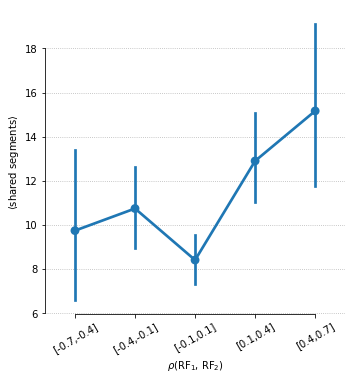

In [23]:
"""
Plots 3 different ones of where compares n_seg_shared (y) vs. binned correlation of the receptive field
"""
g = sns.catplot('bcorr', 'n_seg_shared', data=cdf, kind='point', legend_out=True, sharey=False)
g.set_axis_labels(x_var=r'$\rho$(RF$_1$, RF$_2$)', y_var=r'$\langle$shared segments$\rangle$')

for ax in g.axes.ravel():
    ax.yaxis.grid(True, linestyle=':')
    ax.set_xticklabels(cbin_labels, rotation=30)
sns.despine(trim=True)
g.set_titles('{col_name} axons')

g.fig.savefig('figures/average_shared_input_vs_correlation.png', dpi=200)
g.fig.savefig('figures/average_shared_input_vs_correlation.pdf')

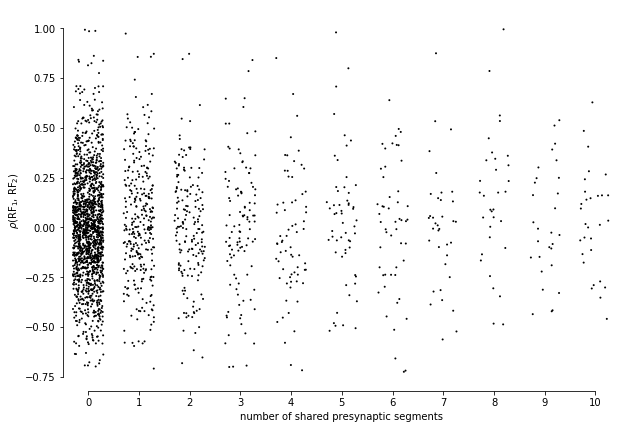

In [24]:
"""
Strip plot is a way of grouping data and ploting them along a continuous value 
- jitter just helps spread out the data points

Conclusion what it graphs:
1) Takes all of the data with number of shared segments less than 11 
and plots the rf correlation coefficiet for those groups

"""
g = sns.stripplot( 'n_seg_shared', 'rf_corr_coef', data=cdf[cdf.n_seg_shared < 11], jitter=0.3, s=2, color='k')
g.set_xlabel(r'number of shared presynaptic segments')
g.set_xticklabels([int(e) for e in g.get_xticks()])
g.set_ylabel(r'$\rho$(RF$_1$, RF$_2$)')
sns.despine(trim=True)
g.figure.set_size_inches((10,7))
g.figure.savefig('figures/shared_input_stripplot.png', dpi=200)
g.figure.savefig('figures/shared_input_stripplot.pdf')

Text(491.6727272727271, 0.5, '$\\langle$Number of pairs in bin$\\rangle$')

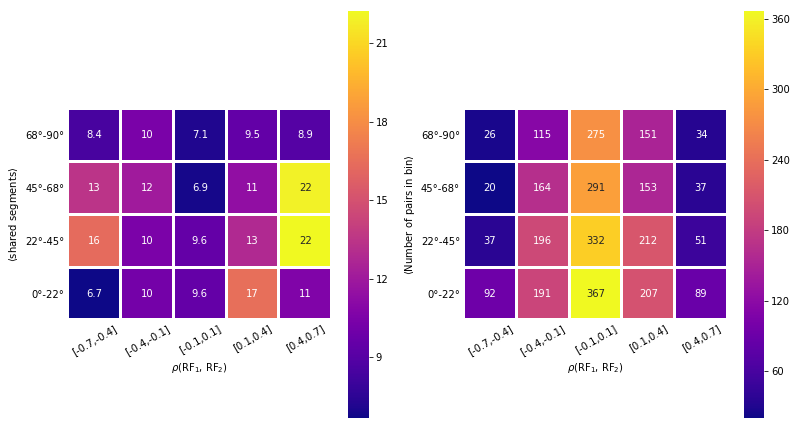

In [25]:
gs = plt.GridSpec(1,2)
fig = plt.figure(figsize=(13,7.5))
ax_heat_shared = fig.add_subplot(gs[0,0])

#groups the pairs by the binned directional orientation and gets the mean of the number of shared segments
df2  = cdf
df2 = df2.groupby(['bdori', 'bcorr'])['n_seg_shared'].mean().reset_index()
#turns the pairs into a pivot table that can be visualized as a heatmap
df2 = df2.pivot('bdori', 'bcorr', 'n_seg_shared')
#graphs the heat map
g = sns.heatmap(df2, square=True, cmap='plasma', annot=True, linewidths=2,ax=ax_heat_shared)
#applys the y labels for the shared segments (have to format it so they will show the degrees)
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
#sets the rf labels and rotates them slightly
g.set_xticklabels(cbin_labels, rotation=30)
#inverts the y axis so that they are going up in value as graph goes up
g.invert_yaxis()
#sets no tick marks
g.tick_params(length=0)
#set labels
g.set_xlabel(r'$\rho$(RF$_1$, RF$_2$)')
g.set_ylabel(r'$\langle$shared segments$\rangle$')

ax_heat_count = fig.add_subplot(gs[0,1])

#groups the pairs by the binned directional orientation and gets the mean of the number of shared segments
df2  = cdf
df2 = df2.groupby(['bdori', 'bcorr'])['n_seg_shared'].count().reset_index()
#turns the pairs into a pivot table that can be visualized as a heatmap
df2 = df2.pivot('bdori', 'bcorr', 'n_seg_shared')
#graphs the heat map
g = sns.heatmap(df2, square=True, cmap='plasma', annot=True, linewidths=2,ax=ax_heat_count,fmt='g')
#applys the y labels for the shared segments (have to format it so they will show the degrees)
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
#sets the rf labels and rotates them slightly
g.set_xticklabels(cbin_labels, rotation=30)
#inverts the y axis so that they are going up in value as graph goes up
g.invert_yaxis()
#sets no tick marks
g.tick_params(length=0)
#set labels
g.set_xlabel(r'$\rho$(RF$_1$, RF$_2$)')
g.set_ylabel(r'$\langle$Number of pairs in bin$\rangle$')



Text(33.0, 0.5, '$\\langle$Number of pairs in bin$\\rangle$')

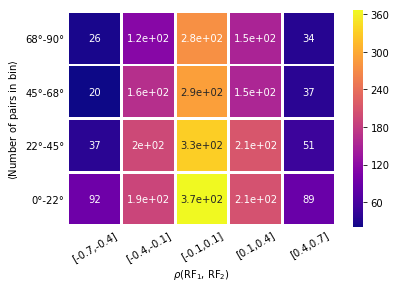

In [26]:
#groups the pairs by the binned directional orientation and gets the mean of the number of shared segments
df2  = cdf
df2 = df2.groupby(['bdori', 'bcorr'])['n_seg_shared'].count().reset_index()
#turns the pairs into a pivot table that can be visualized as a heatmap
df2 = df2.pivot('bdori', 'bcorr', 'n_seg_shared')
#graphs the heat map
g = sns.heatmap(df2, square=True, cmap='plasma', annot=True, linewidths=2)
#applys the y labels for the shared segments (have to format it so they will show the degrees)
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
#sets the rf labels and rotates them slightly
g.set_xticklabels(cbin_labels, rotation=30)
#inverts the y axis so that they are going up in value as graph goes up
g.invert_yaxis()
#sets no tick marks
g.tick_params(length=0)
#set labels
g.set_xlabel(r'$\rho$(RF$_1$, RF$_2$)')
g.set_ylabel(r'$\langle$Number of pairs in bin$\rangle$')


In [27]:
#check that would still get the same bins
union_edges = np.linspace(min(cdf['rf_corr_coef']), max(cdf['rf_corr_coef']), 6)
ue = list(['{:.2f}'.format(ee) for ee in union_edges])
union_labels = list(zip(ue[:-1], ue[1:]))
union_centers = np.hstack((np.nan, np.round((union_edges[1:] + union_edges[:-1])/2, decimals=2), np.nan))
union_centers

array([  nan, -0.55, -0.21,  0.13,  0.48,  0.82,   nan])

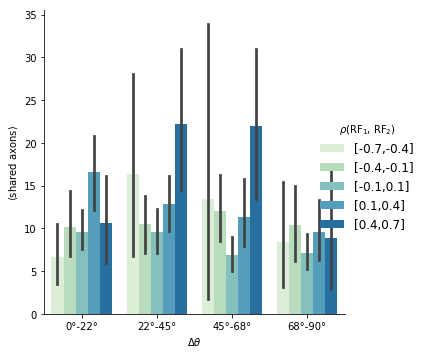

In [28]:
"""
Pulls from the cdf table
Plots the binned difference in orientation (x) vs. average number of shared segments
makes the hue the binned correlation 

but does dso from the cdf so it has to perform the point calculation a nd includes a distribution bar



"""
g = sns.catplot('bdori', 'n_seg_shared', hue='bcorr', kind='bar', palette=sns.color_palette('GnBu', n_colors=5), data=cdf, legend=False)
g.add_legend(prop={'size':12})
g.set_axis_labels(x_var=r'$\Delta \theta$', y_var=r'$\langle$shared axons$\rangle$')
g.set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
new_labels = cbin_labels
g._legend.set_title(r'$\rho$(RF$_1$, RF$_2$)')
for t, l in zip(g._legend.texts, new_labels): 
    t.set_text(l)

sns.despine()
g.fig.savefig('figures/corr_vs_shared_input_bar.png', dpi=200)
g.fig.savefig('figures/corr_vs_shared_input_bar.pdf')

In [29]:
#want to print out the number of segments in each bin